In [ ]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import os
import random
import yaml
from ultralytics import YOLO
import cv2
import shutil
import tempfile
import warnings
warnings.filterwarnings('ignore')

def load_labelme_annotations(data_dir):
    all_dir = Path(data_dir) / 'all'
    json_files = list(all_dir.glob('*.json'))
    
    annotations = []
    for json_path in json_files:
        with open(json_path, 'r', encoding='utf-8') as f:
            ann = json.load(f)
        
        img_path = all_dir / ann['imagePath']
        if not img_path.exists():
            continue
        
        shapes = ann.get('shapes', [])
        if not shapes:
            continue
        
        annotations.append({
            'img_path': str(img_path),
            'shapes': shapes,
            'image_height': ann['imageHeight'],
            'image_width': ann['imageWidth']
        })
    
    if not annotations:
        return pd.DataFrame(), pd.DataFrame()
    
    ann_df = pd.DataFrame(annotations)
    train_indices = random.sample(range(len(ann_df)), int(len(ann_df) * 0.8))
    val_indices = [i for i in range(len(ann_df)) if i not in train_indices]
    
    return ann_df.iloc[train_indices].reset_index(drop=True), ann_df.iloc[val_indices].reset_index(drop=True)

In [ ]:
def prepare_yolo_data(yolo_dir, train_ann, val_ann, class_to_idx):
    for split, ann_df in [('train', train_ann), ('val', val_ann)]:
        split_dir = yolo_dir / split
        split_dir.mkdir(exist_ok=True)
        
        images_dir = split_dir / 'images'
        labels_dir = split_dir / 'labels'
        images_dir.mkdir(exist_ok=True)
        labels_dir.mkdir(exist_ok=True)
        
        for _, row in ann_df.iterrows():
            img_path = Path(row['img_path'])
            shutil.copy(img_path, images_dir / img_path.name)
            
            label_path = labels_dir / f"{img_path.stem}.txt"
            with open(label_path, 'w') as f:
                for shape in row['shapes']:
                    label = shape['label']
                    if label not in class_to_idx:
                        continue
                    
                    points = shape['points']
                    if len(points) < 3:
                        continue
                    
                    normalized_points = []
                    for point in points:
                        if len(point) == 2:
                            x = point[0] / row['image_width']
                            y = point[1] / row['image_height']
                            normalized_points.extend([x, y])
                    
                    if not normalized_points:
                        continue
                    
                    class_id = class_to_idx[label] - 1
                    line = f"{class_id} " + " ".join([f"{p:.6f}" for p in normalized_points])
                    f.write(line + "\n")
    
    return yolo_dir

def create_yolo_config(yolo_dir, class_to_idx):
    config_data = {
        'path': str(yolo_dir),
        'train': 'train/images',
        'val': 'val/images',
        'nc': len(class_to_idx),
        'names': list(class_to_idx.keys())
    }
    
    config_path = yolo_dir / 'data.yaml'
    with open(config_path, 'w') as f:
        yaml.dump(config_data, f, default_flow_style=False)
    
    return config_path


In [ ]:
def train_model_with_params(config_path, params, train_dir, device):
    train_dir.mkdir(exist_ok=True)
    
    model_size = params['model_size']
    if model_size == 'nano':
        model_name = 'yolo11n.pt'
    elif model_size == 'small':
        model_name = 'yolo11s.pt'
    elif model_size == 'medium':
        model_name = 'yolo11m.pt'
    else:
        model_name = 'yolo11l.pt'
    
    model = YOLO(model_name)
    
    train_params = {
        'data': str(config_path),
        'epochs': params['epochs'],
        'imgsz': params['imgsz'],
        'batch': params['batch_size'],
        'patience': 10,
        'device': device,
        'workers': 0,
        'seed': 42,
        'pretrained': True,
        'optimizer': params['optimizer'],
        'lr0': params['lr0'],
        'weight_decay': params['weight_decay'],
        'label_smoothing': params['label_smoothing'],
        'dropout': params['dropout'],
        'freeze': params['freeze_layers'],
        'save': True,
        'save_period': 0,
        'exist_ok': True,
        'project': str(train_dir),
        'name': 'train',
        'verbose': False,
    }
    
    if params['augmentation']:
        train_params.update({
            'augment': True,
            'hsv_h': params['hsv_h'],
            'hsv_s': params['hsv_s'],
            'hsv_v': params['hsv_v'],
            'degrees': params['degrees'],
            'translate': params['translate'],
            'scale': params['scale'],
            'fliplr': params['fliplr'],
        })
    else:
        train_params['augment'] = False
    
    results = model.train(**train_params)
    
    best_model_path = train_dir / 'train' / 'weights' / 'best.pt'
    
    return best_model_path, results

In [ ]:
def plot_simple_training_metrics(results_path):
    csv_path = results_path / 'results.csv'
    if not csv_path.exists():
        return
    
    df = pd.read_csv(csv_path)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Метрики обучения', fontsize=14, fontweight='bold')
    
    ax1 = axes[0, 0]
    if 'train/box_loss' in df.columns:
        ax1.plot(df['train/box_loss'], label='Box Loss', linewidth=2)
    if 'val/box_loss' in df.columns:
        ax1.plot(df['val/box_loss'], label='Val Box Loss', linewidth=2)
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Потери')
    ax1.set_title('Потери (Loss)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[0, 1]
    if 'metrics/precision(B)' in df.columns:
        ax2.plot(df['metrics/precision(B)'], label='Precision', linewidth=2)
    if 'metrics/recall(B)' in df.columns:
        ax2.plot(df['metrics/recall(B)'], label='Recall', linewidth=2)
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Значение')
    ax2.set_title('Precision и Recall', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = axes[1, 0]
    if 'metrics/mAP50(B)' in df.columns:
        ax3.plot(df['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2, color='green')
    if 'metrics/mAP50-95(B)' in df.columns:
        ax3.plot(df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2, color='blue')
    ax3.set_xlabel('Эпоха')
    ax3.set_ylabel('mAP')
    ax3.set_title('mAP метрики', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4 = axes[1, 1]
    if 'lr/pg0' in df.columns:
        ax4.plot(df['lr/pg0'], label='Learning Rate', linewidth=2, color='purple')
        ax4.set_xlabel('Эпоха')
        ax4.set_ylabel('Learning Rate')
        ax4.set_title('Скорость обучения', fontsize=12)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, val_ann, class_to_idx, n_samples=4):
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    indices = random.sample(range(len(val_ann)), min(n_samples, len(val_ann)))
    
    for plot_idx, data_idx in enumerate(indices):
        row = val_ann.iloc[data_idx]
        img_path = row['img_path']
        
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        results = model.predict(image_rgb, conf=0.5, iou=0.5, verbose=False)[0]
        
        ax = axes[plot_idx]
        ax.imshow(image_rgb)
        
        if results.boxes is not None and len(results.boxes) > 0:
            boxes = results.boxes.xyxy.cpu().numpy()
            labels = results.boxes.cls.cpu().numpy()
            scores = results.boxes.conf.cpu().numpy()
            
            for box, label, score in zip(boxes, labels, scores):
                if score < 0.5:
                    continue
                
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                
                rect = patches.Rectangle((x1, y1), width, height, 
                                       linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                
                class_name = idx_to_class.get(label + 1, f'Class {label}')
                ax.text(x1, y1 - 5, f'{class_name}: {score:.2f}', 
                       color='red', fontsize=9, fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))
        
        ax.axis('off')
        ax.set_title(f'Пример {plot_idx + 1}', fontsize=11)
    
    for idx in range(len(indices), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Визуализация предсказаний модели (conf > 0.5)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:


data_dir = ""  # Вставьте путь к папке с данными
yaml_path = "best_hyperparameters.yaml"

with open(yaml_path, 'r') as f:
    yaml_data = yaml.safe_load(f)

best_params = yaml_data['best_params']
best_params['epochs'] = yaml_data.get('final_epochs', best_params['epochs'])
classes = yaml_data['classes']
class_to_idx = {label: i + 1 for i, label in enumerate(classes)}

train_ann, val_ann = load_labelme_annotations(data_dir)

if train_ann.empty or val_ann.empty:
    exit(1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir = Path(temp_dir)
    yolo_dir = temp_dir / "data"
    yolo_dir.mkdir(exist_ok=True)
    
    yolo_dir = prepare_yolo_data(yolo_dir, train_ann, val_ann, class_to_idx)
    config_path = create_yolo_config(yolo_dir, class_to_idx)
    
    train_dir = temp_dir / "train_results"
    best_model_path, final_results = train_model_with_params(
        config_path, best_params, train_dir, device
    )
    
    if best_model_path.exists():
        final_model_path = Path('best_trained_model.pt')
        shutil.copy(best_model_path, final_model_path)
        
        best_model = YOLO(str(final_model_path))
        
        val_results = best_model.val(
            data=str(config_path),
            split='val',
            verbose=False
        )
        
        results_csv_path = train_dir / 'train' / 'results.csv'
        if results_csv_path.exists():
            plot_simple_training_metrics(results_csv_path.parent)
        
        visualize_predictions(best_model, val_ann, class_to_idx)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
import timm
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import optuna
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:

class FixedConfig:
    data_dir = "marb"
    model_name = "efficientvit_b1.r224_in1k"
    img_size = 224
    num_workers = 0
    grad_clip = 1.0
    use_focal_loss = True
    focal_gamma = 2.0
    focal_alpha = 0.25
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

fixed_cfg = FixedConfig()

torch.manual_seed(fixed_cfg.seed)
np.random.seed(fixed_cfg.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(fixed_cfg.seed)


def get_transforms(is_train):
    if is_train:
        return transforms.Compose([
            transforms.Resize((fixed_cfg.img_size, fixed_cfg.img_size)),
            transforms.RandomResizedCrop(
                fixed_cfg.img_size,
                scale=(0.7, 1.0),             
                ratio=(0.9, 1.1)              
            ),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.15), 
            transforms.RandomRotation(10),           
            transforms.ColorJitter(
                brightness=0.25,              
                contrast=0.25,
                saturation=0.20,                
                hue=0.02
            ),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
            transforms.RandomErasing(
                p=0.25,
                scale=(0.02, 0.08),
                ratio=(0.3, 3.3)
            ),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])

    else:
        return transforms.Compose([
            transforms.Resize((fixed_cfg.img_size, fixed_cfg.img_size)),
            transforms.CenterCrop(fixed_cfg.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])



In [ ]:

class MarblingDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}
        
        class_dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        class_dirs.sort() 
        
        for idx, cls in enumerate(class_dirs):
            self.classes.append(cls)
            self.class_to_idx[cls] = idx
            
            cls_path = os.path.join(root, cls)
            if not os.path.exists(cls_path):
                print(f"Warning: Directory {cls_path} does not exist")
                continue
                
            image_files = [f for f in os.listdir(cls_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.bmp'))]
            
            for f in image_files:
                self.samples.append((os.path.join(cls_path, f), idx))
        
        if len(self.samples) == 0:
            raise ValueError(f"No images found in {root}")
        
        print(f"Dataset initialized with {len(self.classes)} classes: {self.classes}")
        print(f"Total images: {len(self.samples)}")
        
        labels = [label for _, label in self.samples]
        unique_labels = set(labels)
        print(f"Unique labels found: {sorted(unique_labels)}")
        
        if max(labels) >= len(self.classes):
            raise ValueError(f"Label {max(labels)} found but only {len(self.classes)} classes exist")
        
    def __len__(self): 
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            img = Image.new('RGB', (fixed_cfg.img_size, fixed_cfg.img_size), color='black')
        
        if self.transform:
            img = self.transform(img)
        
        if label < 0 or label >= len(self.classes):
            print(f"Warning: Invalid label {label} for image {path}")
            label = 0
        
        return img, label

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss


In [ ]:
def get_sampler_for_subset(subset):
    try:
        labels = []
        for i in range(len(subset)):
            try:
                _, label = subset[i]
                labels.append(label)
            except Exception as e:
                print(f"Error getting label for index {i}: {e}")
                labels.append(0)
        
        if not labels:
            return None
            
        unique_labels = np.unique(labels)
        class_counts = np.bincount(labels, minlength=len(np.unique(labels)))
        
        class_counts = np.where(class_counts == 0, 1, class_counts)
        weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
        
        sample_weights = weights[labels]
        
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        return sampler
    except Exception as e:
        print(f"Error creating sampler: {e}")
        return None

In [ ]:
def train_epoch(model, loader, criterion, optimizer, epoch, total_epochs):
    model.train()
    total_loss = correct = total = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{total_epochs}')
    for batch_idx, (x, y) in enumerate(pbar):
        x, y = x.to(fixed_cfg.device), y.to(fixed_cfg.device)
        
        if torch.isnan(x).any() or torch.isinf(x).any():
            print(f"NaN or Inf in batch {batch_idx}")
            continue
            
        optimizer.zero_grad()
        outputs = model(x)
        
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print(f"NaN or Inf in model outputs")
            continue
            
        loss = criterion(outputs, y)
        
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf in loss")
            continue
            
        loss.backward()
        
        if fixed_cfg.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), fixed_cfg.grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item() * x.size(0)
        pred = outputs.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/max(total,1):.2f}%'
        })
    
    return total_loss / max(total, 1), 100. * correct / max(total, 1)

In [80]:
@torch.no_grad()
def validate(model, loader):
    model.eval()
    correct = total = 0
    preds, labels = [], []
    
    for x, y in loader:
        x = x.to(fixed_cfg.device)
        outputs = model(x)
        pred = outputs.argmax(1)
        correct += (pred == y.to(fixed_cfg.device)).sum().item()
        total += y.size(0)
        preds.extend(pred.cpu().numpy())
        labels.extend(y.cpu().numpy())
    
    return 100. * correct / max(total, 1), preds, labels

In [ ]:
def train_single_fold(train_loader, val_loader, num_classes, params, return_model=False):
    print(f"Training with {num_classes} classes")
    
    model = timm.create_model(
        fixed_cfg.model_name, 
        pretrained=True, 
        num_classes=num_classes,
        drop_rate=params['dropout_rate']
    ).to(fixed_cfg.device)
    
    print(f"Model initialized on {fixed_cfg.device}")
    print(f"Number of classes: {num_classes}")
    
    if fixed_cfg.use_focal_loss:
        criterion = FocalLoss(alpha=fixed_cfg.focal_alpha, gamma=fixed_cfg.focal_gamma)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=params['label_smoothing'])
    
    # Phase 1: Training head only
    print("Phase 1: Training head only...")
    for p in model.parameters():
        p.requires_grad = False
    for p in model.head.parameters():
        p.requires_grad = True
    
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=params['lr_head'],
        weight_decay=params['weight_decay']
    )
    
    scheduler = CosineAnnealingLR(optimizer, T_max=params['num_epochs_head'])
    
    best_val_acc = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(params['num_epochs_head']):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer,
            epoch, params['num_epochs_head']
        )
        
        scheduler.step()
        val_acc, _, _ = validate(model, val_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1:03d}/{params['num_epochs_head']:03d} | "
              f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | "
              f"Loss: {train_loss:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_phase1.pth")
            print(f"  → New best! (Val: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            
        if patience_counter >= params['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if os.path.exists("best_phase1.pth"):
        model.load_state_dict(torch.load("best_phase1.pth", map_location=fixed_cfg.device))
    
    # Phase 2: Fine-tuning entire model
    print("\nPhase 2: Fine-tuning entire model...")
    
    for p in model.parameters():
        p.requires_grad = True
    
    optimizer = optim.AdamW(
        model.parameters(),
        lr=params['lr_full'],
        weight_decay=params['weight_decay']
    )
    
    scheduler = CosineAnnealingLR(optimizer, T_max=params['num_epochs_full'])
    
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(params['num_epochs_full']):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer,
            epoch, params['num_epochs_full']
        )
        
        scheduler.step()
        val_acc, _, _ = validate(model, val_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1:03d}/{params['num_epochs_full']:03d} | "
              f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | "
              f"Loss: {train_loss:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f"  → New best! (Val: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            
        if patience_counter >= params['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth", map_location=fixed_cfg.device))
    
    if return_model:
        return best_val_acc, model, history
    else:
        del model
        if os.path.exists("best_phase1.pth"):
            os.remove("best_phase1.pth")
        if os.path.exists("best_model.pth"):
            os.remove("best_model.pth")
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        return best_val_acc, history

In [81]:
def objective(trial):
    params = {
        'batch_size': trial.suggest_int('batch_size', 4, 16),
        'num_epochs_head': trial.suggest_int('num_epochs_head', 5, 15),
        'num_epochs_full': trial.suggest_int('num_epochs_full', 20, 40),
        'lr_head': trial.suggest_loguniform('lr_head', 1e-4, 1e-2),
        'lr_full': trial.suggest_loguniform('lr_full', 1e-6, 1e-4),
        'weight_decay': trial.suggest_loguniform('weight_decay', 1e-3, 0.5),
        'label_smoothing': trial.suggest_uniform('label_smoothing', 0.0, 0.2),
        'dropout_rate': trial.suggest_uniform('dropout_rate', 0.0, 0.5),
        'patience': trial.suggest_int('patience', 3, 10)
    }
    
    dataset = MarblingDataset(fixed_cfg.data_dir)
    
    idx = np.arange(len(dataset))
    labels = [dataset.samples[i][1] for i in idx]
    
    train_idx, val_idx = train_test_split(
        idx, test_size=0.2, stratify=labels, random_state=fixed_cfg.seed
    )
    
    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)
    
    train_ds.dataset.transform = get_transforms(is_train=True)
    val_ds.dataset.transform = get_transforms(is_train=False)
    
    sampler = get_sampler_for_subset(train_ds)
    
    train_loader = DataLoader(
        train_ds,
        batch_size=params['batch_size'],
        sampler=sampler if sampler else None,
        shuffle=(sampler is None),
        num_workers=fixed_cfg.num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=fixed_cfg.num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    print(f"Training on {len(train_ds)} samples, validating on {len(val_ds)} samples")
    val_acc, _ = train_single_fold(
        train_loader,
        val_loader,
        len(dataset.classes),
        params=params
    )
    
    del dataset
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return val_acc

In [ ]:
def plot_class_distribution(class_counts, class_names):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, class_counts)
    plt.title('Distribution of Marbling Classes', fontsize=16)
    plt.xlabel('Marbling Class', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.xticks(rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def train_final_model(best_params, dataset):
    idx = np.arange(len(dataset))
    labels = [dataset.samples[i][1] for i in idx]
    
    train_val_idx, test_idx = train_test_split(
        idx, test_size=0.1, stratify=labels, random_state=fixed_cfg.seed
    )
    
    train_idx, val_idx = train_test_split(
        train_val_idx, test_size=0.1, stratify=[labels[i] for i in train_val_idx],
        random_state=fixed_cfg.seed
    )
    
    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)
    test_ds = Subset(dataset, test_idx)
    
    train_ds.dataset.transform = get_transforms(is_train=True)
    val_ds.dataset.transform = get_transforms(is_train=False)
    test_ds.dataset.transform = get_transforms(is_train=False)
    
    sampler = get_sampler_for_subset(train_ds)
    
    train_loader = DataLoader(
        train_ds,
        batch_size=best_params['batch_size'],
        sampler=sampler if sampler else None,
        shuffle=(sampler is None),
        num_workers=fixed_cfg.num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=best_params['batch_size'],
        shuffle=False,
        num_workers=fixed_cfg.num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    test_loader = DataLoader(
        test_ds,
        batch_size=best_params['batch_size'],
        shuffle=False,
        num_workers=fixed_cfg.num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    final_acc, final_model, history = train_single_fold(
        train_loader, val_loader, len(dataset.classes), params=best_params, return_model=True
    )
    
    test_acc, test_preds, test_labels = validate(final_model, test_loader)
    
    balanced_acc = balanced_accuracy_score(test_labels, test_preds) * 100
    kappa = cohen_kappa_score(test_labels, test_preds, weights='quadratic')
    
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.2f}%")
    print(f"Cohen's Kappa: {kappa:.3f}")
    
    cm = confusion_matrix(test_labels, test_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix (Accuracy: {test_acc:.2f}%, Kappa: {kappa:.3f})', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"\nClassification Report:")
    print(classification_report(
        test_labels, test_preds,
        target_names=dataset.classes,
        digits=4,
        zero_division=0
    ))
    
    torch.save({
        'model_state_dict': final_model.state_dict(),
        'classes': dataset.classes,
        'class_to_idx': dataset.class_to_idx,
        'accuracy': test_acc,
        'balanced_accuracy': balanced_acc,
        'kappa_score': kappa,
        'img_size': fixed_cfg.img_size,
        'model_name': fixed_cfg.model_name,
        'config': {**fixed_cfg.__dict__, **best_params},
    }, "marbling_model_final.pth")
    
    print(f"\n✅ Final model saved as 'marbling_model_final.pth'")
    print(f"🎯 Test Accuracy: {test_acc:.2f}%")
    print(f"🎯 Balanced Accuracy: {balanced_acc:.2f}%")
    print(f"🎯 Cohen's Kappa: {kappa:.3f}")

    if os.path.exists("best_phase1.pth"):
        os.remove("best_phase1.pth")
    if os.path.exists("best_model.pth"):
        os.remove("best_model.pth")

In [ ]:
def main():
    print(f"Device: {fixed_cfg.device}")
    print(f"Model: {fixed_cfg.model_name}")
    print(f"Image size: {fixed_cfg.img_size}")
    
    print("\nLoading dataset...")
    try:
        dataset = MarblingDataset(fixed_cfg.data_dir)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return
    
    print(f"Classes: {dataset.classes}")
    print(f"Class mapping: {dataset.class_to_idx}")
    print(f"Total images: {len(dataset)}")
    
    class_counts = np.zeros(len(dataset.classes))
    for _, label in dataset.samples:
        if label < len(class_counts):
            class_counts[label] += 1
    
    print(f"\nClass distribution:")
    for cls, count in zip(dataset.classes, class_counts):
        print(f"  {cls}: {int(count)} ({count/len(dataset)*100:.1f}%)")
    
    plot_class_distribution(class_counts, dataset.classes)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=15)
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    best_params = trial.params
    train_final_model(best_params, dataset)

In [ ]:
main()

In [4]:


def predict_marbl(model_path, image, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    checkpoint = torch.load(model_path, map_location=device)
    
    # Определяем модель в зависимости от типа чекпоинта
    model_name = checkpoint.get('model_name', 'convnextv2_tiny.fcmae_ft_in22k_in1k_384')
    num_classes = len(checkpoint['classes'])
    img_size = checkpoint.get('img_size', 384)
    dropout_rate = checkpoint.get('config', {}).get('dropout_rate', 0.0)
    model = timm.create_model(
        model_name=model_name,
        pretrained=False,
        num_classes = num_classes,
        dropout_rate = dropout_rate
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    img_size = checkpoint.get('img_size', 384)
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        pred_prob, pred_idx = torch.max(probs, 1)
    
    predicted_class = checkpoint['classes'][pred_idx.item()]
    confidence = pred_prob.item()    
    return predicted_class, confidence

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from torchvision import transforms
import timm
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import optuna
import random
import gc
import time
warnings.filterwarnings('ignore')

# ====================== CONFIG ======================
class Config:
    seed = 42
    data_dir = "steak"
    model_name = "convnextv2_base.fcmae_ft_in22k_in1k_384"
    img_size = 384
    batch_size = 8
    num_workers = 4
    num_epochs_head = 10
    num_epochs_full = 30
    lr_head = 1e-3
    lr_full = 2e-5
    warmup_epochs = 3
    weight_decay = 0.1
    label_smoothing = 0.15
    dropout_rate = 0.5
    patience = 5
    use_focal_loss = True
    focal_gamma = 2.0
    focal_alpha = 0.25
    grad_clip = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optuna_n_trials = 15
    optuna_head_epochs = 10
    optuna_full_epochs = 30
cfg = Config()

# Установка seed для воспроизводимости
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(cfg.seed)
    torch.cuda.manual_seed_all(cfg.seed)


In [ ]:
# ====================== АУГМЕНТАЦИИ ======================
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.2, 0.2, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
# Упрощенные аугментации для Optuna
optuna_train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [ ]:
# ====================== ДАТАСЕТ ======================
class SteakDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        for cls in self.classes:
            cls_path = os.path.join(root, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.bmp')):
                    self.samples.append((os.path.join(cls_path, f), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:
# ====================== LOSS FUNCTIONS ======================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        
    def forward(self, x, target):
        log_probs = F.log_softmax(x, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


In [ ]:
# ====================== ОПТИМИЗИРОВАННОЕ ОБУЧЕНИЕ ДЛЯ OPTUNA ======================
def train_optuna_trial(train_loader, val_loader, num_classes, trial_params):
    """Оптимизированное обучение для Optuna с балансом качества и скорости"""
    print(f"\n Starting Optuna trial with params:")
    for k, v in trial_params.items():
        print(f" {k}: {v}")
    
    try:
        # Создаем модель
        model = timm.create_model(
            cfg.model_name,
            pretrained=True,
            num_classes=num_classes,
            drop_rate=trial_params['dropout_rate']
        ).to(cfg.device)
        
        # Лосс функция
        if trial_params['use_focal_loss']:
            criterion = FocalLoss(alpha=trial_params['focal_alpha'], gamma=trial_params['focal_gamma'])
        else:
            criterion = LabelSmoothingCrossEntropy(trial_params['label_smoothing'])
        
        # Фаза 1: Только голова
        for p in model.parameters():
            p.requires_grad = False
        for p in model.head.parameters():
            p.requires_grad = True
        
        optimizer = optim.AdamW(
            model.head.parameters(),
            lr=trial_params['lr_head'],
            weight_decay=trial_params['weight_decay']
        )
        
        scheduler = CosineAnnealingLR(optimizer, T_max=cfg.optuna_head_epochs)
        best_val_acc_phase1 = 0
        patience_counter = 0
        
        for epoch in range(cfg.optuna_head_epochs):
            # Обучение
            model.train()
            total_loss = correct = total = 0
            pbar = tqdm(train_loader, desc=f'Head Epoch {epoch+1}/{cfg.optuna_head_epochs}')
            for x, y in pbar:
                x, y = x.to(cfg.device), y.to(cfg.device)
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                
                if trial_params.get('grad_clip', 1.0) > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), trial_params['grad_clip'])
                
                optimizer.step()
                
                total_loss += loss.item() * x.size(0)
                pred = outputs.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
            
            scheduler.step()
            
            # Валидация
            model.eval()
            val_correct = val_total = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(cfg.device)
                    outputs = model(x)
                    pred = outputs.argmax(1)
                    val_correct += (pred == y.to(cfg.device)).sum().item()
                    val_total += y.size(0)
            
            val_acc = 100. * val_correct / max(val_total, 1)
            train_acc = 100. * correct / max(total, 1)
            train_loss = total_loss / max(total, 1)
            
            print(f"Head Epoch {epoch+1}/{cfg.optuna_head_epochs} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | Loss: {train_loss:.4f}")
            
            if val_acc > best_val_acc_phase1:
                best_val_acc_phase1 = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Ранняя остановка
            if patience_counter >= 3:
                print(f"Early stopping head phase at epoch {epoch+1}")
                break
        
        # Фаза 2: Полная модель
        for p in model.parameters():
            p.requires_grad = True
        
        optimizer = optim.AdamW(
            model.parameters(),
            lr=trial_params['lr_full'],
            weight_decay=trial_params['weight_decay']
        )
        
        scheduler = CosineAnnealingLR(optimizer, T_max=cfg.optuna_full_epochs)
        best_val_acc = best_val_acc_phase1
        patience_counter = 0
        
        for epoch in range(cfg.optuna_full_epochs):
            # Обучение
            model.train()
            total_loss = correct = total = 0
            pbar = tqdm(train_loader, desc=f'Full Epoch {epoch+1}/{cfg.optuna_full_epochs}')
            for x, y in pbar:
                x, y = x.to(cfg.device), y.to(cfg.device)
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                
                if trial_params.get('grad_clip', 1.0) > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), trial_params['grad_clip'])
                
                optimizer.step()
                
                total_loss += loss.item() * x.size(0)
                pred = outputs.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
            
            scheduler.step()
            
            # Валидация
            model.eval()
            val_correct = val_total = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(cfg.device)
                    outputs = model(x)
                    pred = outputs.argmax(1)
                    val_correct += (pred == y.to(cfg.device)).sum().item()
                    val_total += y.size(0)
            
            val_acc = 100. * val_correct / max(val_total, 1)
            train_acc = 100. * correct / max(total, 1)
            train_loss = total_loss / max(total, 1)
            
            print(f"Full Epoch {epoch+1}/{cfg.optuna_full_epochs} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | Loss: {train_loss:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Ранняя остановка
            if patience_counter >= 3:
                print(f"Early stopping full phase at epoch {epoch+1}")
                break
        
        print(f" Trial completed. Best validation accuracy: {best_val_acc:.2f}%")
        
        # Очистка памяти
        del model, criterion, optimizer, scheduler
        torch.cuda.empty_cache()
        gc.collect()
        
        return best_val_acc
        
    except Exception as e:
        print(f" Error in trial: {e}")
        # Очистка памяти в случае ошибки
        torch.cuda.empty_cache()
        gc.collect()
        return 0.0 # Возвращаем 0 для неудачного trial


In [ ]:
# ====================== OPTUNA OBJECTIVE ======================
def objective(trial):
    """Функция для Optuna с расширенными гиперпараметрами"""
    trial_number = trial.number + 1
    print(f"\n{'='*50}")
    print(f"OPTUNA TRIAL {trial_number}/{cfg.optuna_n_trials}")
    print(f"{'='*50}")
    
    # Гиперпараметры для оптимизации
    trial_params = {
        'lr_head': trial.suggest_float('lr_head', 1e-4, 1e-2, log=True),
        'lr_full': trial.suggest_float('lr_full', 1e-6, 1e-4, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.0, 0.7),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 0.1, log=True),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.3),
        'use_focal_loss': trial.suggest_categorical('use_focal_loss', [True, False]),
        'grad_clip': trial.suggest_float('grad_clip', 0.5, 2.0),
    }
    
    # Добавляем параметры для Focal Loss если используется
    if trial_params['use_focal_loss']:
        trial_params['focal_alpha'] = trial.suggest_float('focal_alpha', 0.1, 0.5)
        trial_params['focal_gamma'] = trial.suggest_float('focal_gamma', 1.0, 3.0)
    
    # Создаем DataLoader с параметрами trial
    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)
    
    # Используем упрощенные аугментации для Optuna
    train_ds.dataset.transform = optuna_train_tfms
    val_ds.dataset.transform = val_tfms
    
    train_loader = DataLoader(
        train_ds,
        batch_size=trial_params['batch_size'],
        shuffle=True,
        num_workers=2, # Меньше workers для Optuna
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=trial_params['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Обучаем и оцениваем
    start_time = time.time()
    val_acc = train_optuna_trial(train_loader, val_loader, len(dataset.classes), trial_params)
    elapsed_time = time.time() - start_time
    
    print(f" Trial {trial_number} took {elapsed_time:.1f} seconds")
    print(f" Accuracy: {val_acc:.2f}%")
    
    return val_acc


In [ ]:
# ====================== ФУНКЦИИ ДЛЯ ФИНАЛЬНОГО ОБУЧЕНИЯ ======================
def train_epoch_full(model, loader, criterion, optimizer, epoch, total_epochs, phase):
    """Полная версия обучения для финальной модели"""
    model.train()
    total_loss = correct = total = 0
    
    pbar = tqdm(loader, desc=f'{phase} Epoch {epoch+1}/{total_epochs}')
    for x, y in pbar:
        x, y = x.to(cfg.device), y.to(cfg.device)
        
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        
        if cfg.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item() * x.size(0)
        pred = outputs.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return total_loss / max(total, 1), 100. * correct / max(total, 1)

def validate_full(model, loader):
    """Полная версия валидации"""
    model.eval()
    correct = total = 0
    preds, labels = [], []
    
    pbar = tqdm(loader, desc='Validation')
    for x, y in pbar:
        x = x.to(cfg.device)
        outputs = model(x)
        pred = outputs.argmax(1)
        correct += (pred == y.to(cfg.device)).sum().item()
        total += y.size(0)
        preds.extend(pred.cpu().numpy())
        labels.extend(y.cpu().numpy())
    
    return 100. * correct / max(total, 1), preds, labels

def train_final_model(train_loader, val_loader, test_loader, num_classes):
    """Финальное обучение с лучшими параметрами"""
    print("\n" + "="*60)
    print("FINAL MODEL TRAINING WITH OPTIMIZED HYPERPARAMETERS")
    print("="*60)
    
    model = timm.create_model(
        cfg.model_name,
        pretrained=True,
        num_classes=num_classes,
        drop_rate=cfg.dropout_rate
    ).to(cfg.device)
    
    if cfg.use_focal_loss:
        criterion = FocalLoss(alpha=cfg.focal_alpha, gamma=cfg.focal_gamma)
        print(f"Using Focal Loss (alpha={cfg.focal_alpha}, gamma={cfg.focal_gamma})")
    else:
        criterion = LabelSmoothingCrossEntropy(cfg.label_smoothing)
        print(f"Using Label Smoothing Cross Entropy (smoothing={cfg.label_smoothing})")
    
    # Фаза 1: Только голова
    print("\nPhase 1: Training head only...")
    for p in model.parameters():
        p.requires_grad = False
    for p in model.head.parameters():
        p.requires_grad = True
    
    optimizer = optim.AdamW(
        model.head.parameters(),
        lr=cfg.lr_head,
        weight_decay=cfg.weight_decay
    )
    
    warmup_scheduler = LinearLR(
        optimizer,
        start_factor=0.01,
        end_factor=1.0,
        total_iters=cfg.warmup_epochs
    )
    
    main_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=cfg.num_epochs_head - cfg.warmup_epochs
    )
    
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, main_scheduler],
        milestones=[cfg.warmup_epochs]
    )
    
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(cfg.num_epochs_head):
        train_loss, train_acc = train_epoch_full(
            model, train_loader, criterion, optimizer, epoch, cfg.num_epochs_head, "Head"
        )
        
        scheduler.step()
        
        val_acc, _, _ = validate_full(model, val_loader)
        print(f"Head Epoch {epoch+1:03d}/{cfg.num_epochs_head:03d} | "
              f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | Loss: {train_loss:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_phase1.pth")
            print(f" → New best! (Val: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            
        if patience_counter >= cfg.patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load("best_phase1.pth", map_location=cfg.device))
    
    # Фаза 2: Весь модель
    print("\nPhase 2: Fine-tuning entire model...")
    for p in model.parameters():
        p.requires_grad = True
    
    optimizer = optim.AdamW(
        model.parameters(),
        lr=cfg.lr_full,
        weight_decay=cfg.weight_decay
    )
    
    warmup_scheduler = LinearLR(
        optimizer,
        start_factor=0.01,
        end_factor=1.0,
        total_iters=cfg.warmup_epochs
    )
    
    main_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=cfg.num_epochs_full - cfg.warmup_epochs
    )
    
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, main_scheduler],
        milestones=[cfg.warmup_epochs]
    )
    
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(cfg.num_epochs_full):
        train_loss, train_acc = train_epoch_full(
            model, train_loader, criterion, optimizer, epoch, cfg.num_epochs_full, "Full"
        )
        
        scheduler.step()
        
        val_acc, _, _ = validate_full(model, val_loader)
        print(f"Full Epoch {epoch+1:03d}/{cfg.num_epochs_full:03d} | "
              f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | Loss: {train_loss:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f" → New best! (Val: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            
        if patience_counter >= cfg.patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load("best_model.pth", map_location=cfg.device))
    
    # Финальная оценка
    print("\n" + "="*60)
    print("FINAL EVALUATION ON TEST SET")
    print("="*60)
    
    test_acc, test_preds, test_labels = validate_full(model, test_loader)
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix (Test Accuracy: {test_acc:.2f}%)', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(
        test_labels, test_preds,
        target_names=dataset.classes,
        digits=4
    ))
    
    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(test_labels, test_preds) * 100
    print(f"\nBalanced Accuracy: {balanced_acc:.2f}%")
    
    return model, test_acc, balanced_acc


In [ ]:
# ====================== MAIN ======================
def main():
    global dataset, train_idx, val_idx, test_idx
    
    print(f"Device: {cfg.device}")
    print(f"Model: {cfg.model_name}")
    print(f"Image size: {cfg.img_size}")
    
    # Загрузка датасета
    print("\nLoading dataset...")
    dataset = SteakDataset(cfg.data_dir)
    print(f"Classes: {dataset.classes}")
    print(f"Total images: {len(dataset)}")
    
    # Статистика классов
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset.samples:
        class_counts[label] += 1
    
    print(f"\nClass distribution:")
    for cls, count in zip(dataset.classes, class_counts):
        print(f" {cls}: {count} ({count/len(dataset)*100:.1f}%)")
    
    # Разбиение на train/val/test
    idx = np.arange(len(dataset))
    labels = [dataset.samples[i][1] for i in idx]
    
    train_idx, temp_idx = train_test_split(
        idx, test_size=0.3, stratify=labels, random_state=cfg.seed
    )
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx],
        random_state=cfg.seed
    )
    
    print(f"\nDataset split:")
    print(f" Train: {len(train_idx)} images")
    print(f" Val: {len(val_idx)} images")
    print(f" Test: {len(test_idx)} images")
    
    # Optuna оптимизация
    print("\n" + "="*60)
    print("STARTING HYPERPARAMETER OPTIMIZATION WITH OPTUNA")
    print(f"Number of trials: {cfg.optuna_n_trials}")
    print(f"Head epochs per trial: {cfg.optuna_head_epochs}")
    print(f"Full epochs per trial: {cfg.optuna_full_epochs}")
    print("="*60)
    
    try:
        # Создаем study с pruner для ранней остановки плохих trials
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=cfg.seed),
            pruner=optuna.pruners.MedianPruner(
                n_startup_trials=3,
                n_warmup_steps=5,
                interval_steps=2
            )
        )
        
        # Запускаем оптимизацию
        study.optimize(objective, n_trials=cfg.optuna_n_trials)
        
        print(f"\n{'='*60}")
        print("OPTUNA OPTIMIZATION COMPLETED!")
        print(f"{'='*60}")
        
        # Выводим лучшие параметры
        print(f"\nBest trial:")
        print(f" Value (accuracy): {study.best_value:.2f}%")
        print(" Best hyperparameters:")
        for key, value in study.best_params.items():
            print(f" {key}: {value}")
        
        # Обновляем конфиг лучшими параметрами
        for key, value in study.best_params.items():
            setattr(cfg, key, value)
        
        # Сохраняем результаты Optuna
        import pandas as pd
        df = study.trials_dataframe()
        df.to_csv("optuna_results.csv", index=False)
        print(f"\nOptuna results saved to 'optuna_results.csv'")
        
    except Exception as e:
        print(f"\nError during Optuna optimization: {e}")
        print("Using default parameters...")
    
    # Создаем финальные DataLoader
    print("\nCreating final data loaders...")
    
    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)
    test_ds = Subset(dataset, test_idx)
    
    train_ds.dataset.transform = train_tfms
    val_ds.dataset.transform = val_tfms
    test_ds.dataset.transform = val_tfms
    
    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True
    )
    
    # Финальное обучение
    best_model, final_accuracy, balanced_acc = train_final_model(
        train_loader, val_loader, test_loader, len(dataset.classes)
    )
    
    # Сохраняем модель
    torch.save({
        'model_state_dict': best_model.state_dict(),
        'classes': dataset.classes,
        'class_to_idx': dataset.class_to_idx,
        'accuracy': final_accuracy,
        'balanced_accuracy': balanced_acc,
        'img_size': cfg.img_size,
        'model_name': cfg.model_name,
        'config': cfg.__dict__,
        'optuna_best_params': study.best_params if 'study' in locals() else {},
        'optuna_best_value': study.best_value if 'study' in locals() else 0,
    }, "steak_model_final.pth")
    
    print(f"\n{'='*60}")
    print("TRAINING COMPLETED SUCCESSFULLY!")
    print(f"{'='*60}")
    print(f"✅ Model saved as 'steak_model_final.pth'")
    print(f"🎯 Test Accuracy: {final_accuracy:.2f}%")
    print(f"⚖️ Balanced Accuracy: {balanced_acc:.2f}%")
    
    if 'study' in locals():
        print(f"🔬 Best Optuna trial accuracy: {study.best_value:.2f}%")

main()


C:\Users\MagPC\AppData\Local\Temp\ipykernel_15276\128485437.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


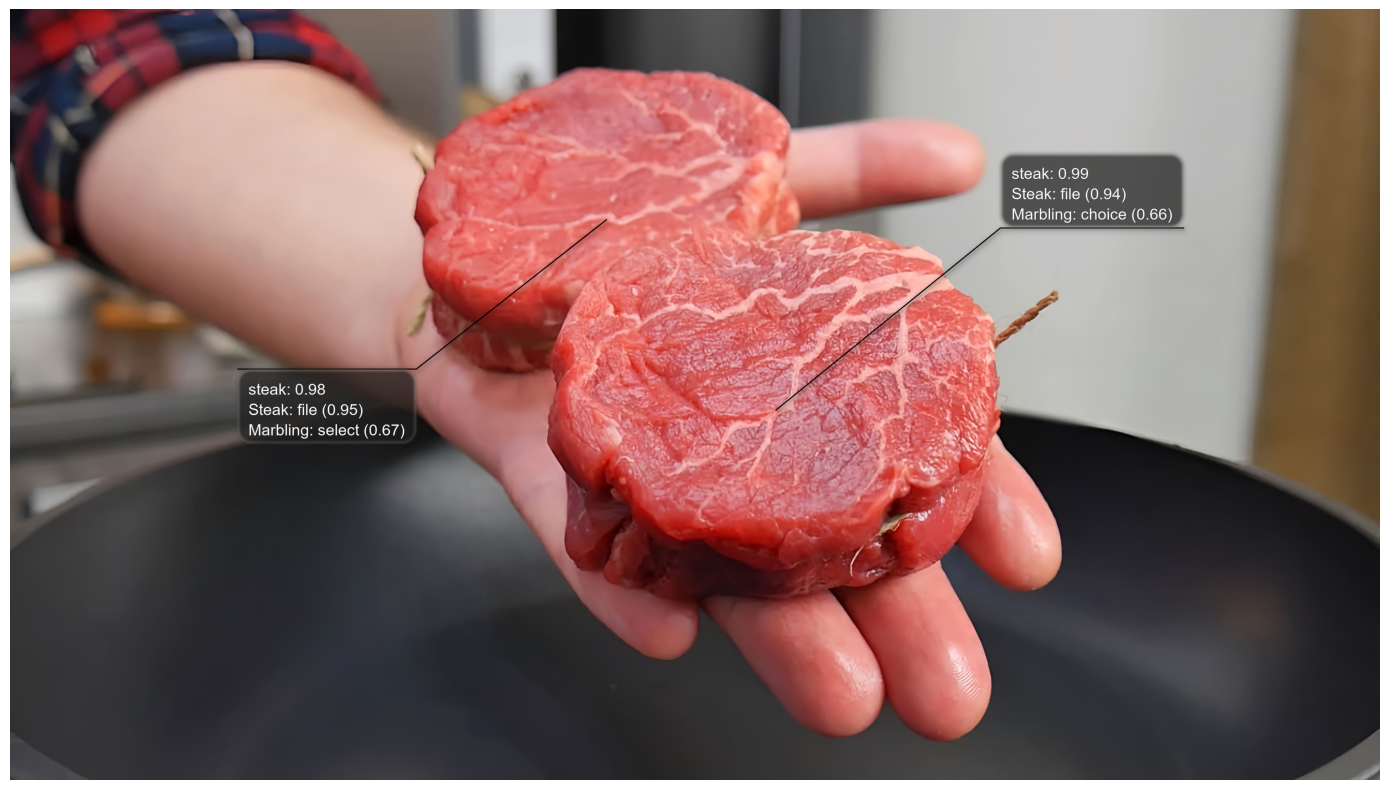

In [83]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

STEAK_MODEL_PATH = 'steak_model_final.pth'
MARB_MODEL_PATH = 'marbling_model_final.pth'
YOLO_MODEL_PATH = 'best_trained_model.pt'

# Трансформации для классификаторов
def get_transform(img_size=384):
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# -----------------------------
# Класс-кеш для загрузки моделей
# -----------------------------
class ModelCache:
    """Кеширует и возвращает загруженные классификационные модели"""
    steak = None
    marb = None
    steak_meta = None
    marb_meta = None

    @staticmethod
    def load_timm_checkpoint(path, device='cpu'):
        ckpt = torch.load(path, map_location=device)
        model = timm.create_model(ckpt['model_name'], pretrained=False, num_classes=len(ckpt['classes']))
        model.load_state_dict(ckpt['model_state_dict'])
        model.to(device)
        model.eval()
        return model, ckpt

    @classmethod
    def get_steak_model(cls, path=STEAK_MODEL_PATH, device='cpu'):
        if cls.steak is None:
            cls.steak, cls.steak_meta = cls.load_timm_checkpoint(path, device=device)
        return cls.steak, cls.steak_meta

    @classmethod
    def get_marb_model(cls, path=MARB_MODEL_PATH, device='cpu'):
        if cls.marb is None:
            cls.marb, cls.marb_meta = cls.load_timm_checkpoint(path, device=device)
        return cls.marb, cls.marb_meta

# -----------------------------
# Батчевые предсказания
# -----------------------------
def batch_predict(model, checkpoint, images, device='cpu'):
    """Предсказание для батча изображений"""
    if len(images) == 0:
        return []

    img_size = checkpoint.get('img_size', 384)
    transform = get_transform(img_size)
    tensors = [transform(Image.fromarray(im)) for im in images]
    
    batch = torch.stack(tensors).to(device)
    with torch.no_grad():
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1)
        confs, idxs = torch.max(probs, dim=1)
    
    return [(checkpoint['classes'][int(i)], float(c)) for c, i in zip(confs.cpu(), idxs.cpu())]

# -----------------------------
# Основная функция визуализации
# -----------------------------
def visualize_prediction_premium(yolo_model, image_path, conf_threshold=0.5, iou_threshold=0.5, device='cpu'):
    # Загрузка изображения
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Изображение не найдено: {image_path}")
    
    h_img, w_img = image_bgr.shape[:2]
    scale_factor = max(h_img, w_img) / 1200
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    # Получение боксов от YOLO
    results = yolo_model.predict(image_rgb, conf=conf_threshold, iou=iou_threshold, verbose=False)[0]
    if results.boxes is None or len(results.boxes) == 0:
        plt.figure(figsize=(10, 8))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
        return

    boxes = results.boxes.xyxy.cpu().numpy()
    labels = results.boxes.cls.cpu().numpy().astype(int)
    scores = results.boxes.conf.cpu().numpy()

    # Подготовка кадров для классификаторов
    crops, crop_indices = [], []
    for i, (box, sc) in enumerate(zip(boxes, scores)):
        if sc < conf_threshold:
            continue
        x1, y1, x2, y2 = [int(round(v)) for v in box]
        x1, x2 = max(0, x1), min(w_img, x2)
        y1, y2 = max(0, y1), min(h_img, y2)
        crop = image_rgb[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        crops.append(crop)
        crop_indices.append(i)

    # Получение предсказаний от классификаторов
    steak_model, steak_meta = ModelCache.get_steak_model(device=device)
    marb_model, marb_meta = ModelCache.get_marb_model(device=device)
    
    steak_preds = batch_predict(steak_model, steak_meta, crops, device=device)
    marb_results = [('No grad', 0.0)] * len(crops)
    
    # Получаем предсказания мраморности только для non-alternative стейков
    marb_inputs = [crops[ci] for ci, (label, _) in enumerate(steak_preds) if label != 'alternative']
    marb_map = [ci for ci, (label, _) in enumerate(steak_preds) if label != 'alternative']
    
    if marb_inputs:
        marb_preds = batch_predict(marb_model, marb_meta, marb_inputs, device=device)
        for i, pred in enumerate(marb_preds):
            marb_results[marb_map[i]] = pred

    # Настройка шрифта
    font_size = max(12, int(14 * scale_factor))
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    # Создаем слои
    pil_image = Image.fromarray(image_rgb)
    shadow_layer = Image.new('RGBA', pil_image.size, (0, 0, 0, 0))
    line_layer = Image.new('RGBA', pil_image.size, (0, 0, 0, 0))
    bg_layer = Image.new('RGBA', pil_image.size, (0, 0, 0, 0))
    text_layer = Image.new('RGBA', pil_image.size, (0, 0, 0, 0))
    
    shadow_draw = ImageDraw.Draw(shadow_layer)
    line_draw = ImageDraw.Draw(line_layer)
    bg_draw = ImageDraw.Draw(bg_layer)
    text_draw = ImageDraw.Draw(text_layer)

    for drawn, i in enumerate(crop_indices):
        box = boxes[i]
        lab = labels[i]
        sc = scores[i]
        x1, y1, x2, y2 = [int(round(v)) for v in box]
        
        # Данные для подписи
        s_label, s_conf = steak_preds[drawn]
        m_label, m_conf = marb_results[drawn]
        det_name = yolo_model.names.get(int(lab), f'class {lab}')
        lines = [
            f"{det_name}: {sc:.2f}",
            f"Steak: {s_label} ({s_conf:.2f})",
            f"Marbling: {m_label} ({m_conf:.2f})"
        ]
        
        # Расчет размеров текста
        temp_draw = ImageDraw.Draw(Image.new('RGBA', (1, 1)))
        text_bboxes = [temp_draw.textbbox((0, 0), line, font=font) for line in lines]
        max_width = max(b[2] - b[0] for b in text_bboxes)
        line_height = text_bboxes[0][3] - text_bboxes[0][1]
        line_spacing = int(8 * scale_factor)
        total_height = line_height * len(lines) + line_spacing * (len(lines) - 1)
        
        # Параметры фона
        bg_padding = int(10 * scale_factor)
        bg_width = max_width + bg_padding * 2
        bg_height = total_height + bg_padding * 2
        
        # Определение позиции текста
        text_x = x2 + bg_padding  # По умолчанию справа
        text_y_start = y1 - total_height - bg_padding  # По умолчанию сверху
        
        # Точные координаты фона (инициализируем ДО условия)
        bg_x1 = text_x - bg_padding
        bg_y1 = text_y_start - bg_padding
        bg_x2 = bg_x1 + bg_width
        bg_y2 = bg_y1 + bg_height
        
        # Проверка границ и определение позиции
        mirror_position = False
        if bg_x2 > w_img or bg_y1 < 0 or bg_y2 > h_img:
            mirror_position = True
            # Зеркальная позиция: слева снизу
            bg_x2 = x1
            bg_x1 = bg_x2 - bg_width
            text_x = bg_x1 + bg_padding
            text_y_start = y2 + bg_padding
            bg_y1 = text_y_start - bg_padding
            bg_y2 = bg_y1 + bg_height
            
            # Точка подключения линии снизу
            top_x, top_y = int(x1), int(y2)
        else:
            # Нормальная позиция: справа сверху
            top_x, top_y = int(x2), int(y1)
        
        center_x, center_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
        
        # Определение конечной точки линии
        line_end_x = bg_x2 if not mirror_position else bg_x1
        
        # Рисуем тень
        shadow_offset = int(1.5 * scale_factor)
        for layer in range(4, 0, -1):
            alpha = int(40 * (layer / 4))
            width = int(1 * scale_factor) + layer
            shadow_draw.line(
                [(center_x + shadow_offset, center_y + shadow_offset),
                 (top_x + shadow_offset, top_y + shadow_offset),
                 (line_end_x + shadow_offset, top_y + shadow_offset)],
                fill=(0, 0, 0, alpha),
                width=width,
                joint='curve'
            )
        
        # Добавляем размытую тень
        soft_shadow = Image.new('RGBA', pil_image.size, (0, 0, 0, 0))
        soft_draw = ImageDraw.Draw(soft_shadow)
        soft_draw.line(
            [(center_x + shadow_offset, center_y + shadow_offset),
             (top_x + shadow_offset, top_y + shadow_offset),
             (line_end_x + shadow_offset, top_y + shadow_offset)],
            fill=(0, 0, 0, 30),
            width=int(6 * scale_factor),
            joint='curve'
        )
        soft_shadow = soft_shadow.filter(ImageFilter.GaussianBlur(radius=int(2 * scale_factor)))
        shadow_layer = Image.alpha_composite(shadow_layer, soft_shadow)

        # Рисуем основную линию
        line_draw.line(
            [(center_x, center_y), (top_x, top_y), (line_end_x, top_y)],
            fill=(0, 0, 0, 255),
            width=max(1, int(1 * scale_factor)),
            joint='curve'
        )
        
        # Создаем фон текста
        radius = int(12 * scale_factor)
        bg_draw.rounded_rectangle(
            [(bg_x1, bg_y1), (bg_x2, bg_y2)],
            radius=radius,
            fill=(30, 30, 30, 180),
            outline=(255, 255, 255, 100),
            width=int(1 * scale_factor)
        )
        
        # Рисуем текст
        current_y = text_y_start
        for line in lines:
            # Тень текста
            text_draw.text((text_x + 1, current_y + 1), line, fill=(0, 0, 0, 200), font=font)
            # Основной текст
            text_draw.text((text_x, current_y), line, fill=(255, 255, 255, 255), font=font)
            current_y += line_height + line_spacing

    # Применяем размытие к фону текста
    bg_layer_blurred = bg_layer.filter(ImageFilter.GaussianBlur(radius=int(1.2 * scale_factor)))
    
    # Собираем результат
    result = pil_image.convert('RGBA')
    result = Image.alpha_composite(result, shadow_layer)
    result = Image.alpha_composite(result, line_layer)
    result = Image.alpha_composite(result, bg_layer_blurred)
    result = Image.alpha_composite(result, text_layer)
    
    # Отображаем результат
    result_image = np.array(result.convert('RGB'))
    plt.figure(figsize=(14, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# -----------------------------
# Утилиты: загрузка YOLO
# -----------------------------
def load_yolo(path, device='cpu'):
    model = YOLO(path)
    try:
        model.to(device)
    except:
        pass
    return model

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    yolo = load_yolo(YOLO_MODEL_PATH, device=device)
    
    # Путь к тестовой фотографии
    TEST_IMAGE = '69l-4zvyLwI_2880.jpg'
    
    # Настройки
    visualize_prediction_premium(yolo, TEST_IMAGE, conf_threshold=0.9, iou_threshold=0.5, device=device)


In [ ]:
transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),